In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using CSV, Plots

In [2]:
function get_molar_volumes(filename::String)
    data = convert(Array{Union{String, Missing}}, CSV.read(filename, header = false))
    title_locations = findall(ismissing, data)
    starts = []
    for title_location in title_locations
        push!(starts, title_location[1])
    end
    push!(starts, length(data) ÷ 2 + 1)
    js = Dict{String, Array{Float64}}()
    molar_volumes = Dict{String, Array{Float64}}()
    for i = 1:length(title_locations)
        rows = (starts[i] + 2):(starts[i + 1] - 1)
        js[data[starts[i], 1]] = parse.(Float64, data[rows, 1])
        molar_volumes[data[starts[i], 1]] = parse.(Float64, data[rows, 2]) ./ 10^6
    end
    return js, molar_volumes
end;

In [3]:
function get_crystal_radii()
    return Dict("Zinc"      => 7.40E-11, 
                "Silver"    => 1.29E-10, 
                "Sodium"    => 1.16E-10, 
                "Lithium"   => 7.30E-11, 
                "Calcium"   => 1.23E-10, 
                "Strontium" => 1.40E-10, 
                "Magnesium" => 7.10E-11, 
                "Tin"       => 9.50E-11,
                "Boron"     => 1.50E-11,
                "Oxygen"    => 1.21E-10)
end;

In [4]:
function get_equations()       #M O B O
    return Dict("Zinc"      => [1 1 2 3], #  xZnO•(1-x)B₂O₃
                "Silver"    => [2 1 2 3], # xAg₂O•(1-x)B₂O₃
                "Sodium"    => [2 1 2 3], # xNa₂O•(1-x)B₂O₃
                "Lithium"   => [2 1 2 3], # xLi₂O•(1-x)B₂O₃
                "Calcium"   => [1 1 2 3], #  xCaO•(1-x)B₂O₃
                "Strontium" => [1 1 2 3], #  xSrO•(1-x)B₂O₃
                "Magnesium" => [1 1 2 3], #  xMgO•(1-x)B₂O₃
                "Tin"       => [1 1 2 3]) #  xSnO•(1-x)B₂O₃
end;

Conversion from $j$ to $x$ is $x = \frac{j}{j+1}$

In [5]:
j_to_x(j) = j / (j + 1);

Volume of a sphere is $V = \frac{4}{3} \pi r^3$

In [6]:
volume(r::Float64) = 4//3 * π * r^3;

For a composition $xM_a O_b \cdot (1-x)B_c O_d$, $PF = \frac{N_A [x(a V_M + b V_O) + (1-x)(c V_B + d V_O)]}{MV_{(xM_a O_b \cdot (1-x)B_c O_d)}}$

In [7]:
function get_packing_fractions(js::Dict{String,Array{Float64}}, 
        molar_volumes::Dict{String,Array{Float64}})
    Nₐ = 6.02214076e23
    crystal_radii = get_crystal_radii()
    equations = get_equations()
    packing_fractions = Dict{String, Array{Float64}}()
    for modifier in keys(js)
        equation = equations[modifier]
        x = j_to_x.(js[modifier])
        packing_fractions[modifier] = (Nₐ * (x * (equation[1] * volume(crystal_radii[modifier]) + 
            equation[2] * volume(crystal_radii["Oxygen"])) + 
            (1 .- x) * (equation[3] * volume(crystal_radii["Boron"]) + 
            equation[4] * volume(crystal_radii["Oxygen"])))) ./ molar_volumes[modifier]
    end
    return packing_fractions
end;

In [16]:
function plot_data(js::Dict{String,Array{Float64}}, 
        data::Dict{String,Array{Float64}}, plot_type::String; exclude::Array{String} = ["nothing"])
    modifiers = collect(keys(data))
    colors = distinguishable_colors(length(modifiers) + 1)[2:end]
    colorsDict = Dict(modifiers[i] => colors[i] for i = 1:length(modifiers))
    y_label = plot_type == "molar volume" ? "Molar Volume (m³/mol)" : "Packing Fraction"
    plt = plot(xlabel = "j", ylabel = y_label)
    for (key, value) in data
        if !(key in exclude) 
            scatter!(plt, js[key], value, label = key, color = colorsDict[key])
        end
    end
    plt
end;

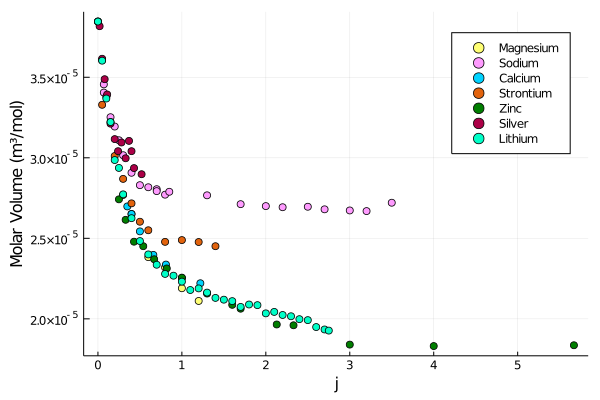

In [9]:
js, molar_volumes = get_molar_volumes("molar-volumes.csv")
plot_data(js, molar_volumes, "molar volume", exclude = ["Tin"])

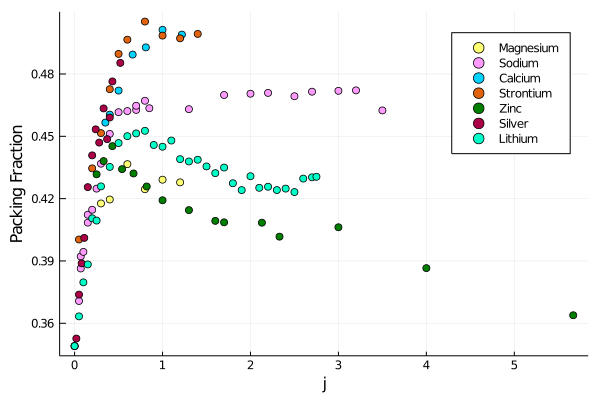

In [19]:
packing_fractions = get_packing_fractions(js, molar_volumes)
plot_data(js, packing_fractions, "packing fraction", exclude = ["Tin"])